# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

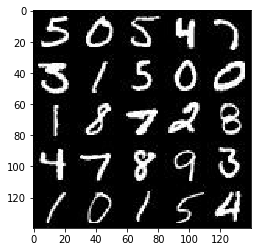

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

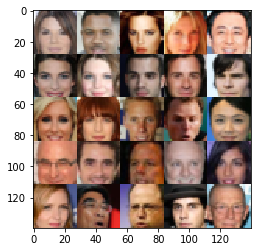

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate') 

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    train = not reuse
    with tf.variable_scope('discriminator', reuse=reuse):
        x1= tf.layers.conv2d(images,64,4, strides=2, padding='same' )
        relu1 = tf.maximum(alpha*x1, x1)
        #14 x 14 x 64
        x2= tf.layers.conv2d(relu1, 128, 4, strides= 2, padding='same')
        x2= tf.layers.batch_normalization(x2, training=train)
        relu2 = tf.maximum(alpha*x2 , x2)
        #7 x 7 x 128
        x3= tf.layers.conv2d(relu2, 256, 4, strides= 2, padding='same')
        x3= tf.layers.batch_normalization(x3, training=train)
        relu3 = tf.maximum(alpha*x3 , x3)
        #4 x 4 x 256
        x4= tf.layers.conv2d(relu3, 512, 4, strides= 2, padding='same')
        x4= tf.layers.batch_normalization(x4, training=train)
        relu4 = tf.maximum(alpha*x4 , x4)
        #2 x 2 x 512
        flat= tf.reshape(relu4, (-1, 4*4*512))
        logits= tf.layers.dense(flat,1)
        out= tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-0.5, 0.5, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learningrate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    samples, losses = [], []
    steps = 0

    print_every=10
    show_every=100
    
    out_channel_dim = 1 if data_image_mode == "L" else 3
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learningrate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                # random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learningrate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real:batch_images, lr:learningrate})
                

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real:batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 50, input_z, out_channel_dim, data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 0.1205... Generator Loss: 2.1905
Epoch 1/2... Discriminator Loss: 0.0538... Generator Loss: 2.9666
Epoch 1/2... Discriminator Loss: 0.0504... Generator Loss: 3.0419
Epoch 1/2... Discriminator Loss: 0.0261... Generator Loss: 3.6873
Epoch 1/2... Discriminator Loss: 0.0131... Generator Loss: 4.3958
Epoch 1/2... Discriminator Loss: 0.0060... Generator Loss: 5.1626
Epoch 1/2... Discriminator Loss: 0.0022... Generator Loss: 6.1482
Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 6.7469
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 7.1296


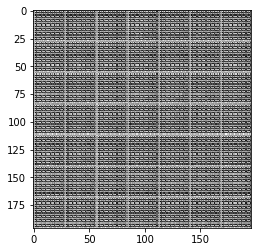

Epoch 1/2... Discriminator Loss: 0.0005... Generator Loss: 7.6966
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.1561
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.4677
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.7112
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.8720
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 8.9687
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.6713
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 7.9285
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.0960
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.2109


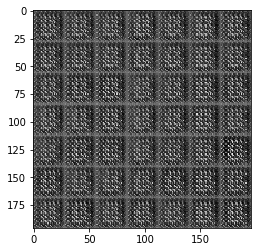

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.2881
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 8.1644
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.7653
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.7878
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.8286
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.0670
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.0976
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.1747
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.0552
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.8295


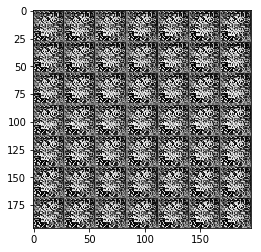

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.1628
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.5313
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.7652
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.6467
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.6239
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.6437
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.3424
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.8963
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.0018
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.1322


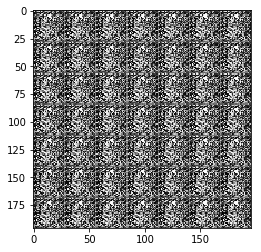

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.2205
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.2707
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.4144
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.5387
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.6264
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.4449
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.5553
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.5475
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.6024
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7031


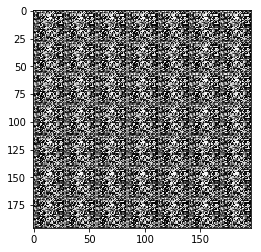

Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.5637
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7639
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7806
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.6977
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7903
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.8184
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.8272
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.8240
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7461
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.6128


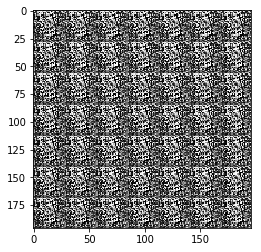

Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.8185
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 10.1998
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 10.4833
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 10.3585
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 10.5148
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 10.2830
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7124
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.1925
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.2908
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.4628


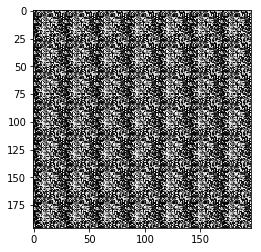

Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.6713
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.6249
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7040
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7749
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.3600
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 10.2992
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 10.3659
Epoch 2/2... Discriminator Loss: 0.0000... Generator Loss: 10.3583
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 10.0518
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7884


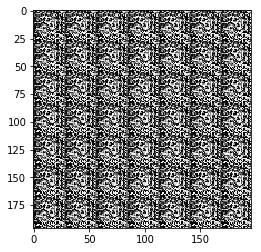

Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.8771
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.8926
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7193
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.4828
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7214
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.9061
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7308
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.9640
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.8417
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.8003


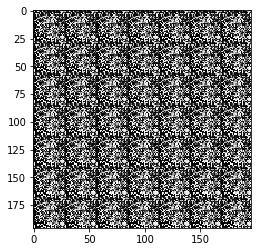

Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.6500
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.7192
Epoch 2/2... Discriminator Loss: 0.0001... Generator Loss: 9.6050


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 0.0894... Generator Loss: 2.4633
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 2.8494
Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 4.1740
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 3.3457
Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 4.1077
Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 4.6712
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 5.3138
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 5.7410
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 6.0409


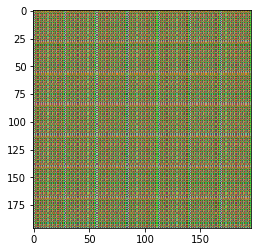

Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 6.0496
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 6.0124
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 6.8171
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.6962
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.4737
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.3573
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.2006
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 6.7530
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 6.9746
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.0895


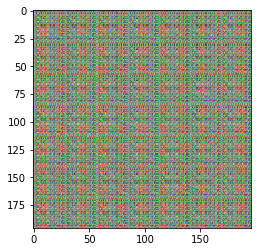

Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.3165
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.5626
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.4964
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.1912
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.6767
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.8003
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.6450
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.2051
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.1112
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.1572


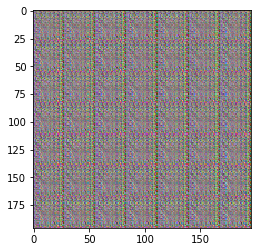

Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.6858
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8653
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.0431
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.9435
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.9814
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.9081
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.1624
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.2252
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.0683
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 6.5157


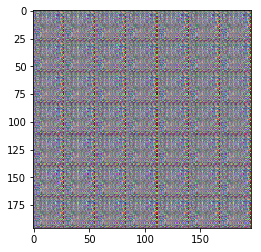

Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.9936
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.6194
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.2625
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.3387
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8803
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 3.9890
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 57.4899
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 14.7314
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 6.9719
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.6921


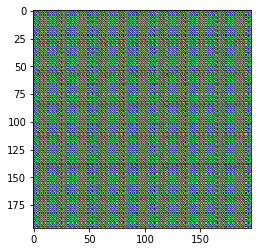

Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 6.2425
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 5.8698
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.3044
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 6.4369
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 6.2063
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 5.4427
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 5.7453
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.1285
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 5.9759
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 5.9032


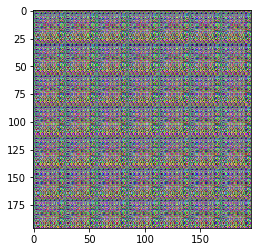

Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 5.8672
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 5.9651
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 5.9401
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 6.0022
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 5.9676
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 5.9191
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.3083
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 6.3515
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.4409
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 6.5510


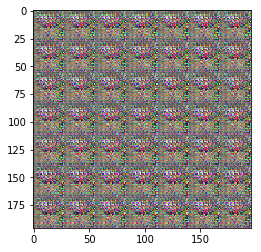

Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.6286
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 5.8453
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.7103
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 6.9915
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 7.1006
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.1683
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.2350
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.4036
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.5294
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.0324


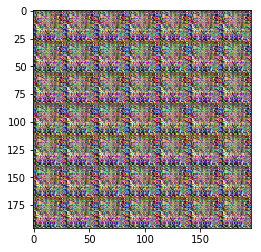

Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.7201
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8478
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.8834
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.0260
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.8415
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.0905
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.9246
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.9035
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 8.0000
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.1008


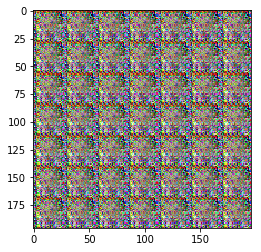

Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.1544
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.1869
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.2755
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 8.0902
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.4212
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.2677
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.4958
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.4407
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.6090
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.6244


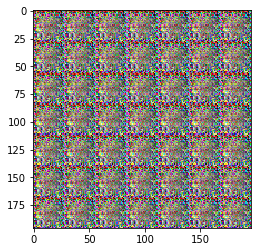

Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 17.4256
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.2876
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.5901
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.5492
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.6086
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.5468
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.6654
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7257
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.5779
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7370


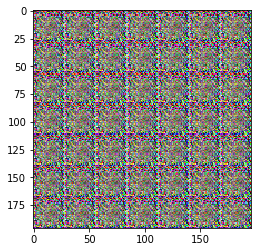

Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7458
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9396
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9209
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9243
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.8672
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 8.9023
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.0439
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0581
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.6009
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.8002


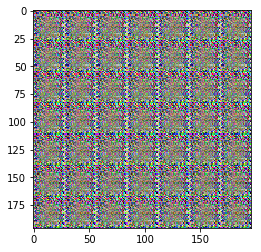

Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.6741
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7360
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7262
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7324
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.6387
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.5462
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.5853
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7238
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.4643
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.6390


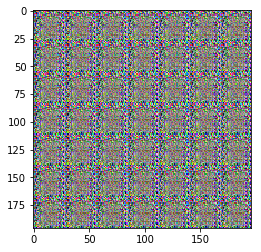

Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.4644
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.6092
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7347
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.6431
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.8658
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7207
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.8535
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.0613
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9153
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9743


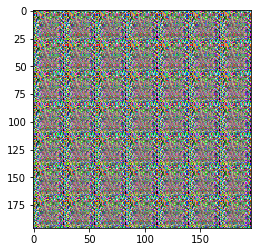

Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.2437
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7502
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7153
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.7698
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.5094
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.0395
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.9803
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8189
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.6163
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.7046


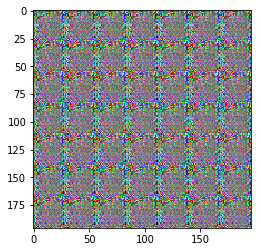

Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.6613
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.8142
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.4404
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.7035
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.9102
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.8643
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.7777
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.7469


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.